In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('./train_data/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [56]:
print('데이터 세트의 Shape:', house_df.shape)
print('전체 피처의 type')
print(house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('Null 칼럼과 그 건수:')
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)
전체 피처의 type
object     43
int64      35
float64     3
dtype: int64
Null 칼럼과 그 건수:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


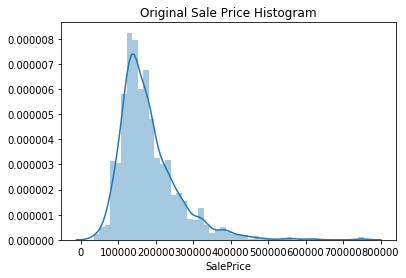

In [57]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

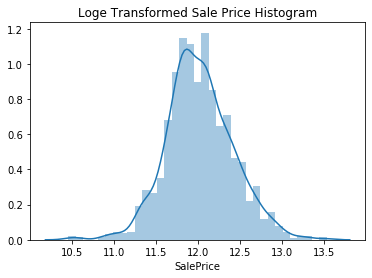

In [58]:
plt.title('Loge Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [59]:
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
house_df.fillna(house_df.mean(), inplace=True)

In [60]:
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type')
print(house_df.dtypes[null_column_count.index])

## Null 피처의 Type
MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [61]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('gt_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type')
print(null_column_count)

get_dummies() 수행 전 데이터 Shape: (1460, 75)
gt_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type
Series([], dtype: int64)


In [62]:
from sklearn.metrics import mean_squared_error

def get_rmse(model):
    pred = model.predict(x_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [63]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

In [64]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579153972, 0.12750846334053156, 0.17628250556471395]

In [65]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=x_features.columns)
    
    coef_sort = coef.sort_values(ascending=False)
    coef_high = coef_sort.head(n)
    coef_low = coef_sort.tail(n)
    return coef_high, coef_low

In [66]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(30, 10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        axs[i_num].set_title(model.__class__.__name__ + 'Coeffiecnets', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

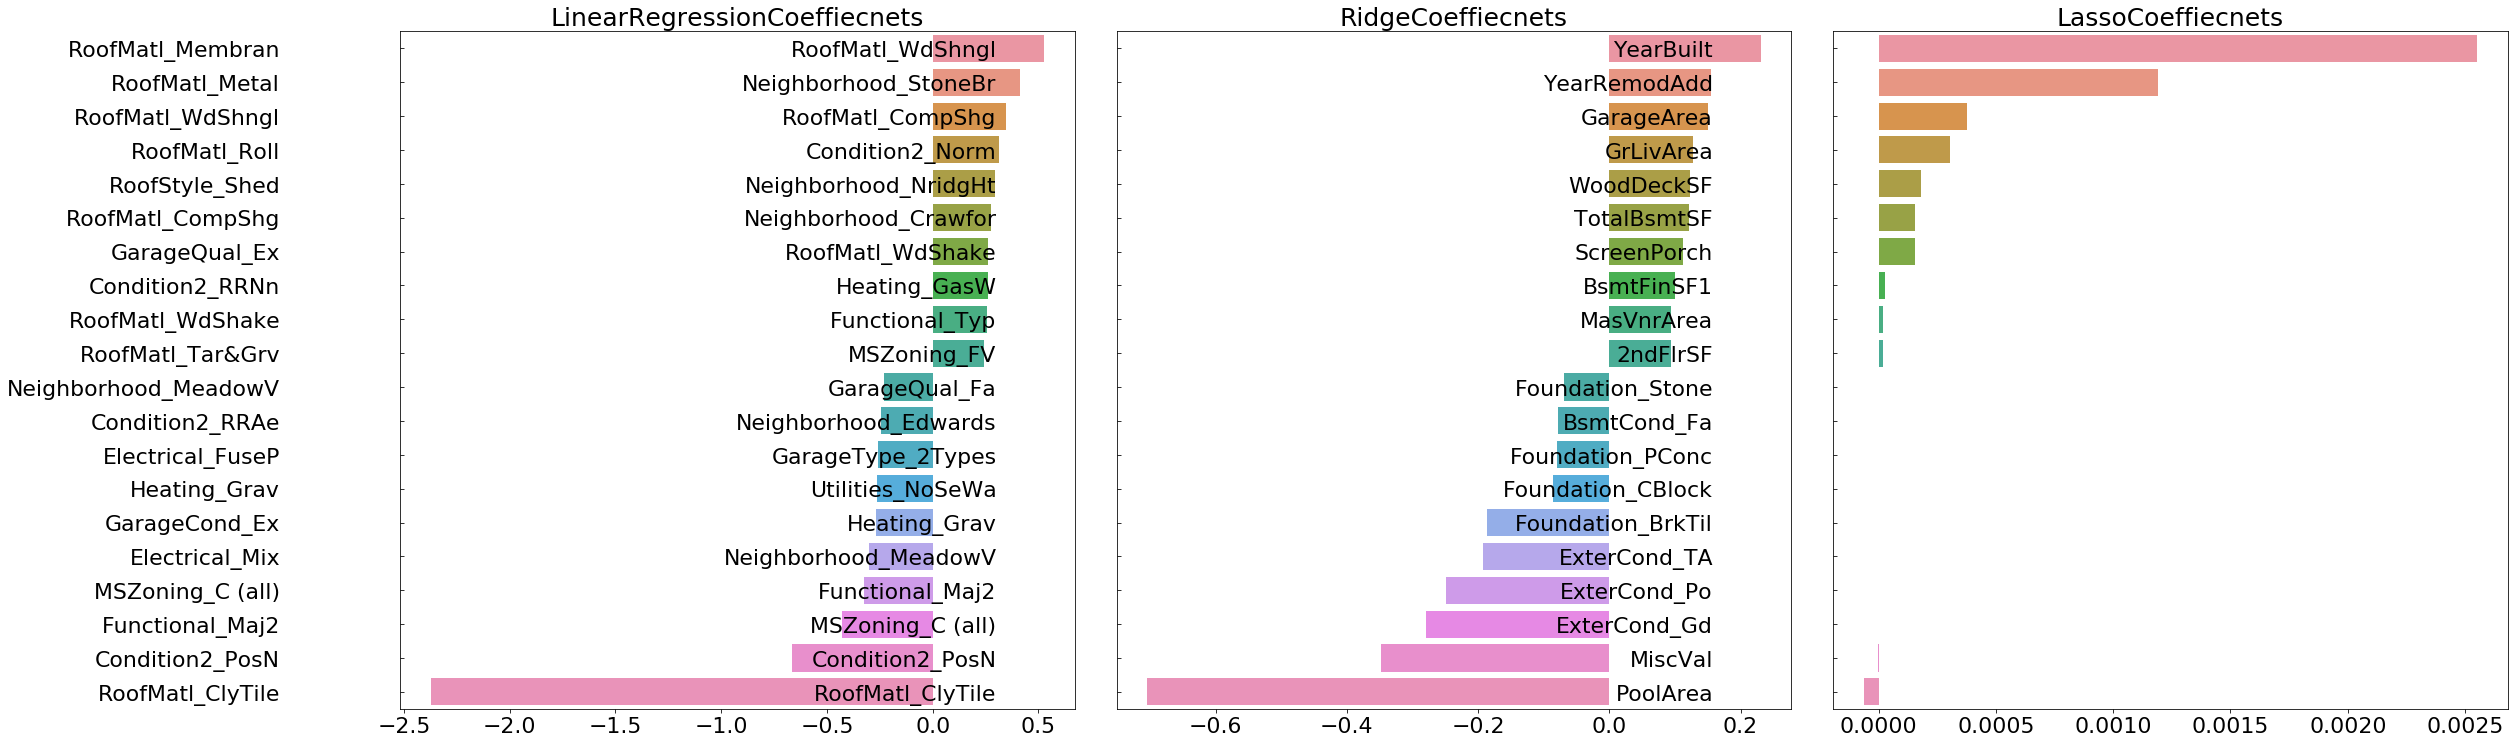

In [67]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [68]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, x_features, y_target, scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print(f'{model.__class__.__name__} CV RMSE 값 리스트: {np.round(rmse_list, 3)}')
        print(f'{model.__class__.__name__} CV 평균 RMSE 값: {np.round(rmse_avg, 3)}')

In [69]:
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155
Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144
Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


In [72]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv=5)
    grid_model.fit(x_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print(f'{model.__class__.__name__} 5 CV시 최적 RMSE 값: {np.round(rmse, 4)}, 최적 alpha: {grid_model.best_params_}')

In [73]:
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 RMSE 값: 0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV시 최적 RMSE 값: 0.142, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


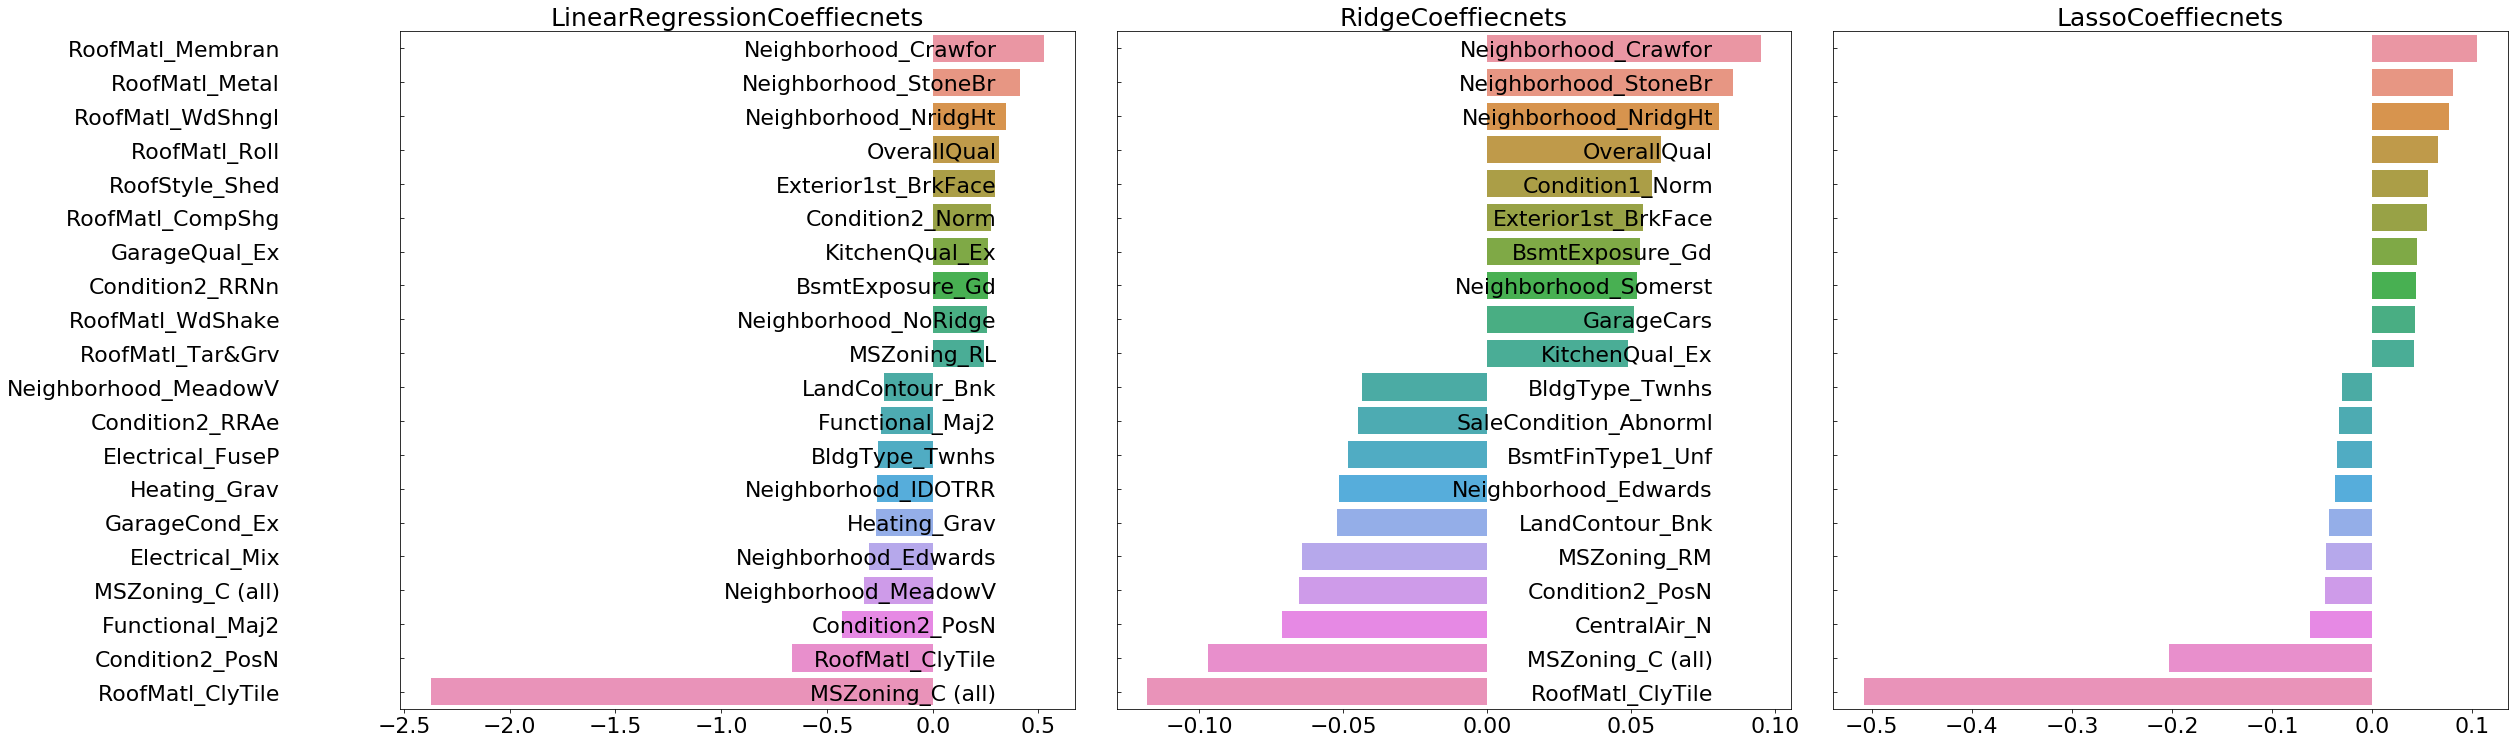

In [74]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [76]:
from scipy.stats import skew

features_index = house_df.dtypes[house_df.dtypes != 'object'].index
skew_features = house_df[features_index].apply(skew)
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [77]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [78]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

In [79]:
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 RMSE 값: 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV시 최적 RMSE 값: 0.1252, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


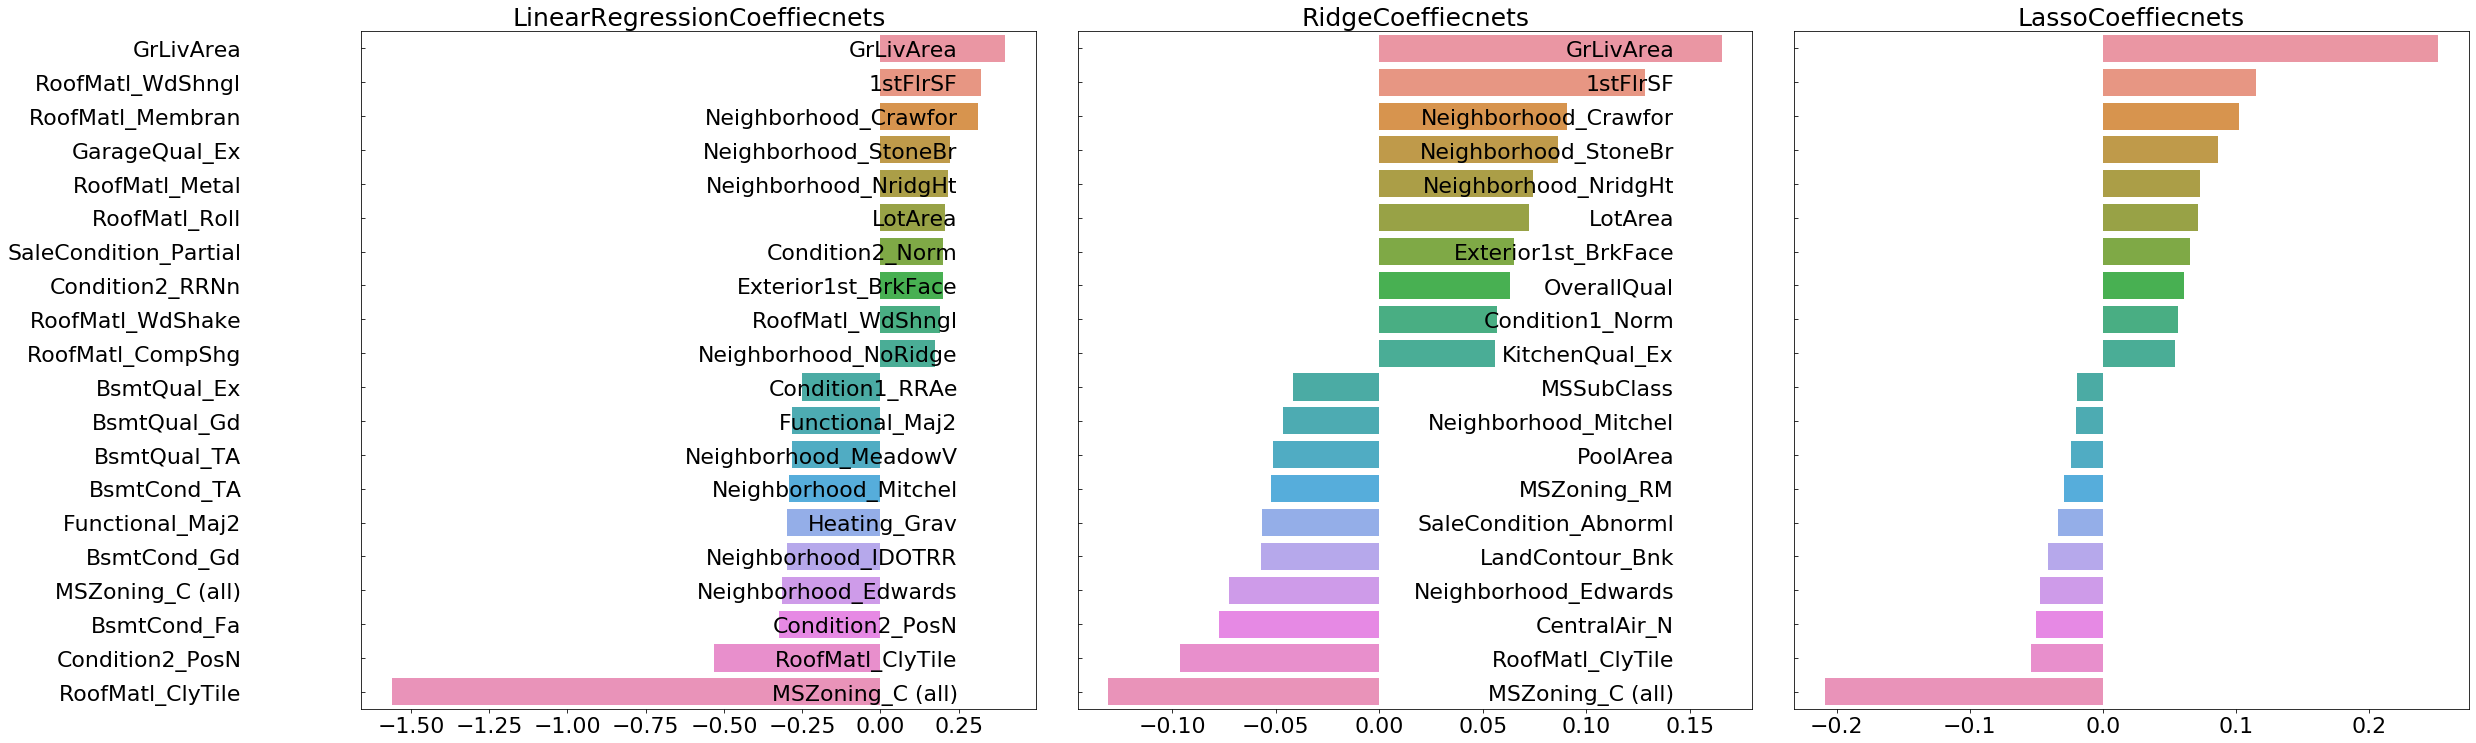

In [80]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

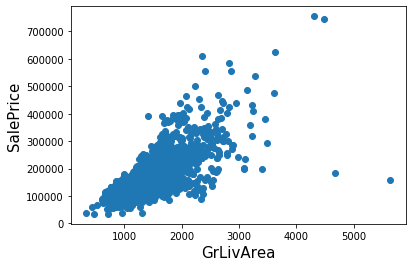

In [81]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [82]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index: [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 271)


In [83]:
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 삭제 후 house_df_ohe shape: (1458, 271)


In [84]:
y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV시 최적 RMSE 값: 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV시 최적 RMSE 값: 0.1122, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


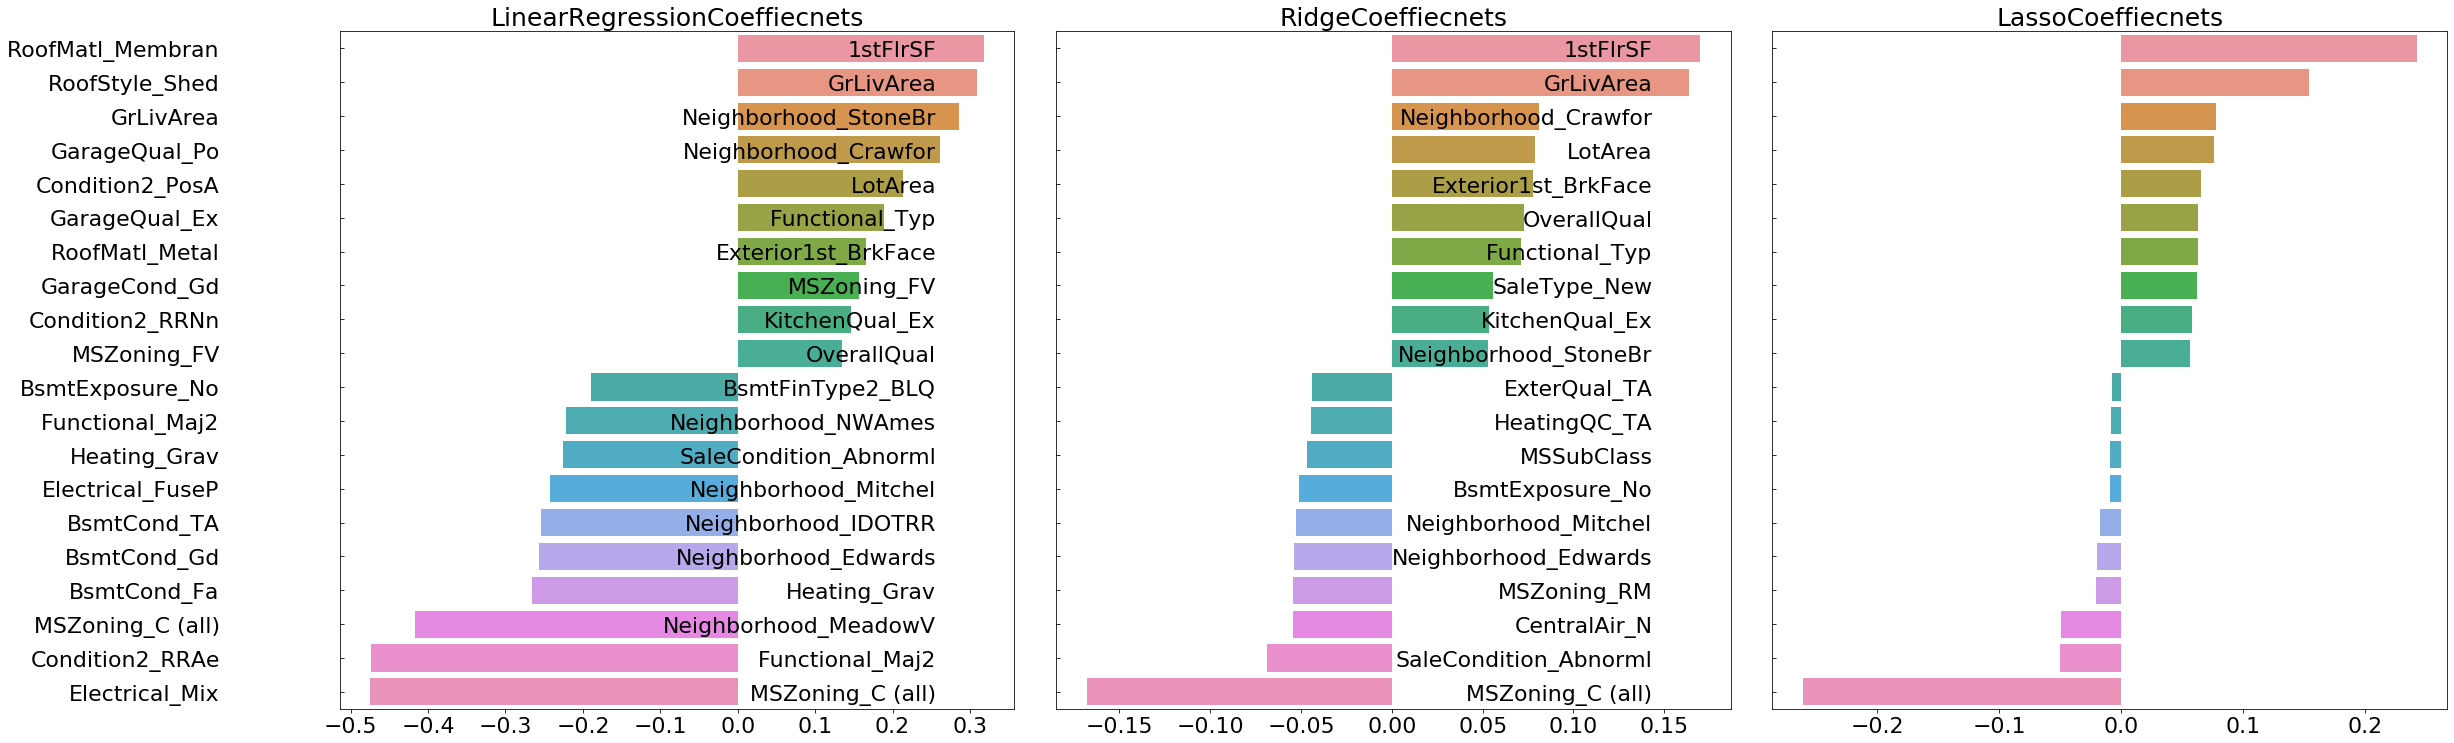

In [85]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [86]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, n_jobs=-1)
print_best_params(xgb_reg, xgb_params)

[20:12:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV시 최적 RMSE 값: 0.115, 최적 alpha: {'n_estimators': 1000}


In [87]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV시 최적 RMSE 값: 0.1165, 최적 alpha: {'n_estimators': 1000}


In [99]:
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(x_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [100]:
xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, n_jobs=-1)
xgb_best = get_best_params(xgb_reg, xgb_params)

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
lgbm_best = get_best_params(lgbm_reg, lgbm_params)

[20:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.115, 최적 alpha:{'n_estimators': 1000}
LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1165, 최적 alpha:{'n_estimators': 1000}


In [89]:
xgb_reg.fit(x_train, y_train)
lgbm_reg.fit(x_train, y_train)

[20:18:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=4, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=10, silent=True,
              subsample=0.6, subsample_for_bin=200000, subsample_freq=0)

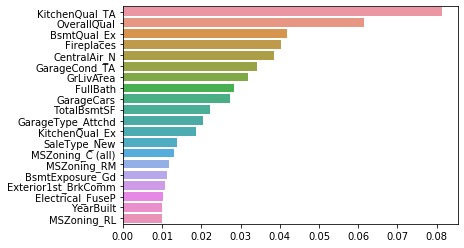

In [94]:
xgb_feature_series = pd.Series(data=xgb_reg.feature_importances_, index=x_features.columns)
xgb_feature_series = xgb_feature_series.sort_values(ascending=False)[:20]
sns.barplot(x=xgb_feature_series, y=xgb_feature_series.index)

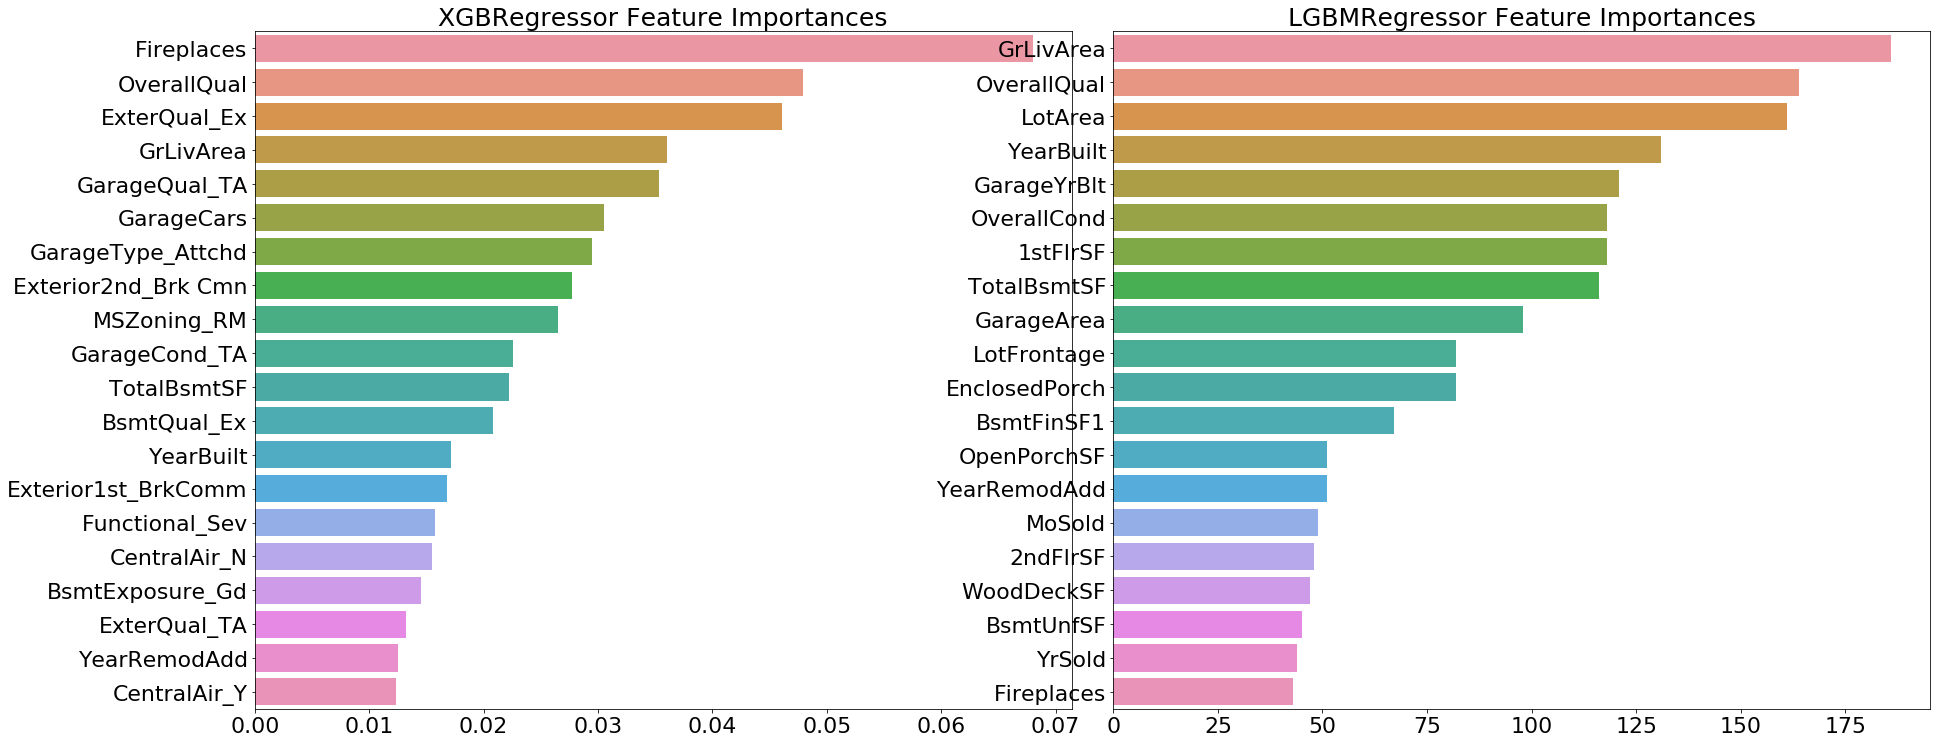

In [104]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=x_features.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

models = [xgb_best, lgbm_best]
visualize_ftr_importances(models)

In [105]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print(f'{key} 모델의 RMSE: {rmse}')

In [106]:
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

ridge_pred = ridge_reg.predict(x_test)
lasso_pred = lasso_reg.predict(x_test)

pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470512
Ridge 모델의 RMSE: 0.1034517754660326
Lasso 모델의 RMSE: 0.10024170460890032


In [108]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, n_jobs=-1)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(x_train, y_train)
lgbm_reg.fit(x_train, y_train)
xgb_pred = xgb_reg.predict(x_test)
lgbm_pred = lgbm_reg.predict(x_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

[20:32:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE: 0.09897715854093485
XGBM 모델의 RMSE: 0.10075115846547565
LGBM 모델의 RMSE: 0.1015065721553885


In [115]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, x_train_n, y_train_n, x_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    
    train_fold_pred = np.zeros((x_train_n.shape[0], 1))
    test_pred = np.zeros((x_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(x_train_n)):
        print('폴드 세트:', folder_counter, '시작')
        x_tr = x_train_n[train_index]
        y_tr = y_train_n[train_index]
        x_te = x_train_n[valid_index]
        
        model.fit(x_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(x_te).reshape(-1, 1)
        test_pred[:, folder_counter] = model.predict(x_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    return train_fold_pred, test_pred_mean

In [116]:
x_train_n = x_train.values
x_test_n = x_test.values
y_train_n = y_train.values

models = [ridge_reg, lasso_reg, xgb_reg, lgbm_reg]
trains = []
tests = []
for model in models:
    model_train, model_test = get_stacking_base_datasets(model, x_train_n, y_train_n, x_test_n, 5)
    trains.append(model_train)
    tests.append(model_test)

C:\Users\Jaehyeong\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\Jaehyeong\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\Jaehyeong\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Ridge model 시작
폴드 세트: 0 시작
폴드 세트: 1 시작
폴드 세트: 2 시작
폴드 세트: 3 시작
폴드 세트: 4 시작
Lasso model 시작
폴드 세트: 0 시작
폴드 세트: 1 시작
폴드 세트: 2 시작
폴드 세트: 3 시작
폴드 세트: 4 시작
XGBRegressor model 시작
폴드 세트: 0 시작
[20:44:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트: 1 시작
[20:44:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트: 2 시작
[20:44:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트: 3 시작
[20:44:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트: 4 시작
[20:44:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor model 시작
폴드 세트: 0 시작
폴드 세트: 1 시작
폴드 세트: 2 시작
폴드 세트: 3 시작
폴드 세트: 4 시작


In [119]:
stack_final_x_train = np.concatenate(trains, axis=1)
stack_final_x_test = np.concatenate(tests, axis=1)

meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(stack_final_x_train, y_train)
final = meta_model_lasso.predict(stack_final_x_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE값은:', rmse)

스태킹 회귀 모델의 최종 RMSE값은: 0.09738961783055028
